# Epidemiology_with_quarantine_event

In [1]:
import numpy as np
import sys
sys.path.append('../GillesPy2')
import gillespy2
from gillespy2.core import Model, Species, Reaction, Parameter, RateRule, AssignmentRule, FunctionDefinition
from gillespy2.core.events import EventAssignment, EventTrigger, Event
# To run a simulation using the SSA Solver simply omit the solver argument from model.run().
# from gillespy2.solvers.cpp.variable_ssa_c_solver import VariableSSACSolver
# from gillespy2.solvers.numpy.basic_tau_leaping_solver import BasicTauLeapingSolver
from gillespy2 import TauHybridSolver
# from gillespy2.solvers.numpy.basic_ode_solver import BasicODESolver

In [2]:
class Epidemiology_with_quarantine_event(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="Epidemiology_with_quarantine_event")
        self.volume = 1

        # Parameters
        self.add_parameter(Parameter(name="exposure", expression=2.6725769102923615e-07))
        self.add_parameter(Parameter(name="exposure_0", expression=2.6725769102923615e-07))
        self.add_parameter(Parameter(name="infect", expression=0.2862670529638084))
        self.add_parameter(Parameter(name="progress", expression=0.350641470244625))
        self.add_parameter(Parameter(name="recovery", expression=1.650750787134925))
        self.add_parameter(Parameter(name="silent_recovery", expression=1.313225037020145))
        self.add_parameter(Parameter(name="death", expression=0.03605770636882821))
        self.add_parameter(Parameter(name="qrate", expression=0.5499237128381103))
        self.add_parameter(Parameter(name="prate", expression=0.5810587750454265))

        # Species
        self.add_species(Species(name="susceptible", initial_value=9999978.0))
        self.add_species(Species(name="exposed", initial_value=0))
        self.add_species(Species(name="infected", initial_value=2))
        self.add_species(Species(name="symptomatic", initial_value=22))
        self.add_species(Species(name="cleared", initial_value=0))
        self.add_species(Species(name="recovered", initial_value=0))
        self.add_species(Species(name="dead", initial_value=0))

        # Reactions
        self.add_reaction(Reaction(name="hie", reactants={'susceptible': 1, 'infected': 1}, products={'infected': 1, 'exposed': 1}, rate='exposure'))
        self.add_reaction(Reaction(name="hse", reactants={'susceptible': 1, 'symptomatic':1}, products={'exposed':1, 'symptomatic': 1}, rate='exposure'))
        self.add_reaction(Reaction(name="e_to_i", reactants={'exposed': 1}, products={'infected': 1}, rate="infect"))
        self.add_reaction(Reaction(name="i_to_s", reactants={'infected': 1}, products={'symptomatic': 1}, rate="progress"))
        self.add_reaction(Reaction(name="i_to_c", reactants={'infected': 1}, products={'cleared': 1}, rate="silent_recovery"))
        self.add_reaction(Reaction(name="s_to_r", reactants={'symptomatic': 1}, products={'recovered': 1}, rate="recovery"))
        self.add_reaction(Reaction(name="s_to_d", reactants={'symptomatic': 1}, products={'dead': 1}, rate="death"))

        # Events
        quarantinet = EventTrigger(expression="t >= 20", initial_value=False, persistent=False)
        quarantinea1 = EventAssignment(variable=self.listOfParameters["exposure"], expression="exposure_0 * qrate")
        self.add_event(Event(name="lockdown_start", trigger=quarantinet, assignments=[quarantinea1], delay=None, priority="0", use_values_from_trigger_time=False))

        phase_1t = EventTrigger(expression="t>= 70", initial_value=False, persistent=False)
        phase_1a1 = EventAssignment(variable=self.listOfParameters["exposure"], expression="exposure_0 * prate")
        self.add_event(Event(name="reopen_start", trigger=phase_1t, assignments=[phase_1a1], delay=None, priority="0", use_values_from_trigger_time=False))

        # Timespan
        self.timespan(np.linspace(0, 119, 120))

In [3]:
model = Epidemiology_with_quarantine_event()

In [4]:
def configure_simulation():
    kwargs = {
        "solver":TauHybridSolver,
        "number_of_trajectories":1,
        # "seed":None,
        # "tau_tol":0.03,
        # "integrator_options":{'rtol': 0.001, 'atol': 1e-06}
    }
    return kwargs

In [5]:
kwargs = configure_simulation()
for species in model.listOfSpecies.values():
    species.mode = 'continuous'
%time results = model.run(**kwargs)

CPU times: user 480 ms, sys: 5.83 ms, total: 485 ms
Wall time: 461 ms


In [6]:
import matplotlib.pyplot as plt

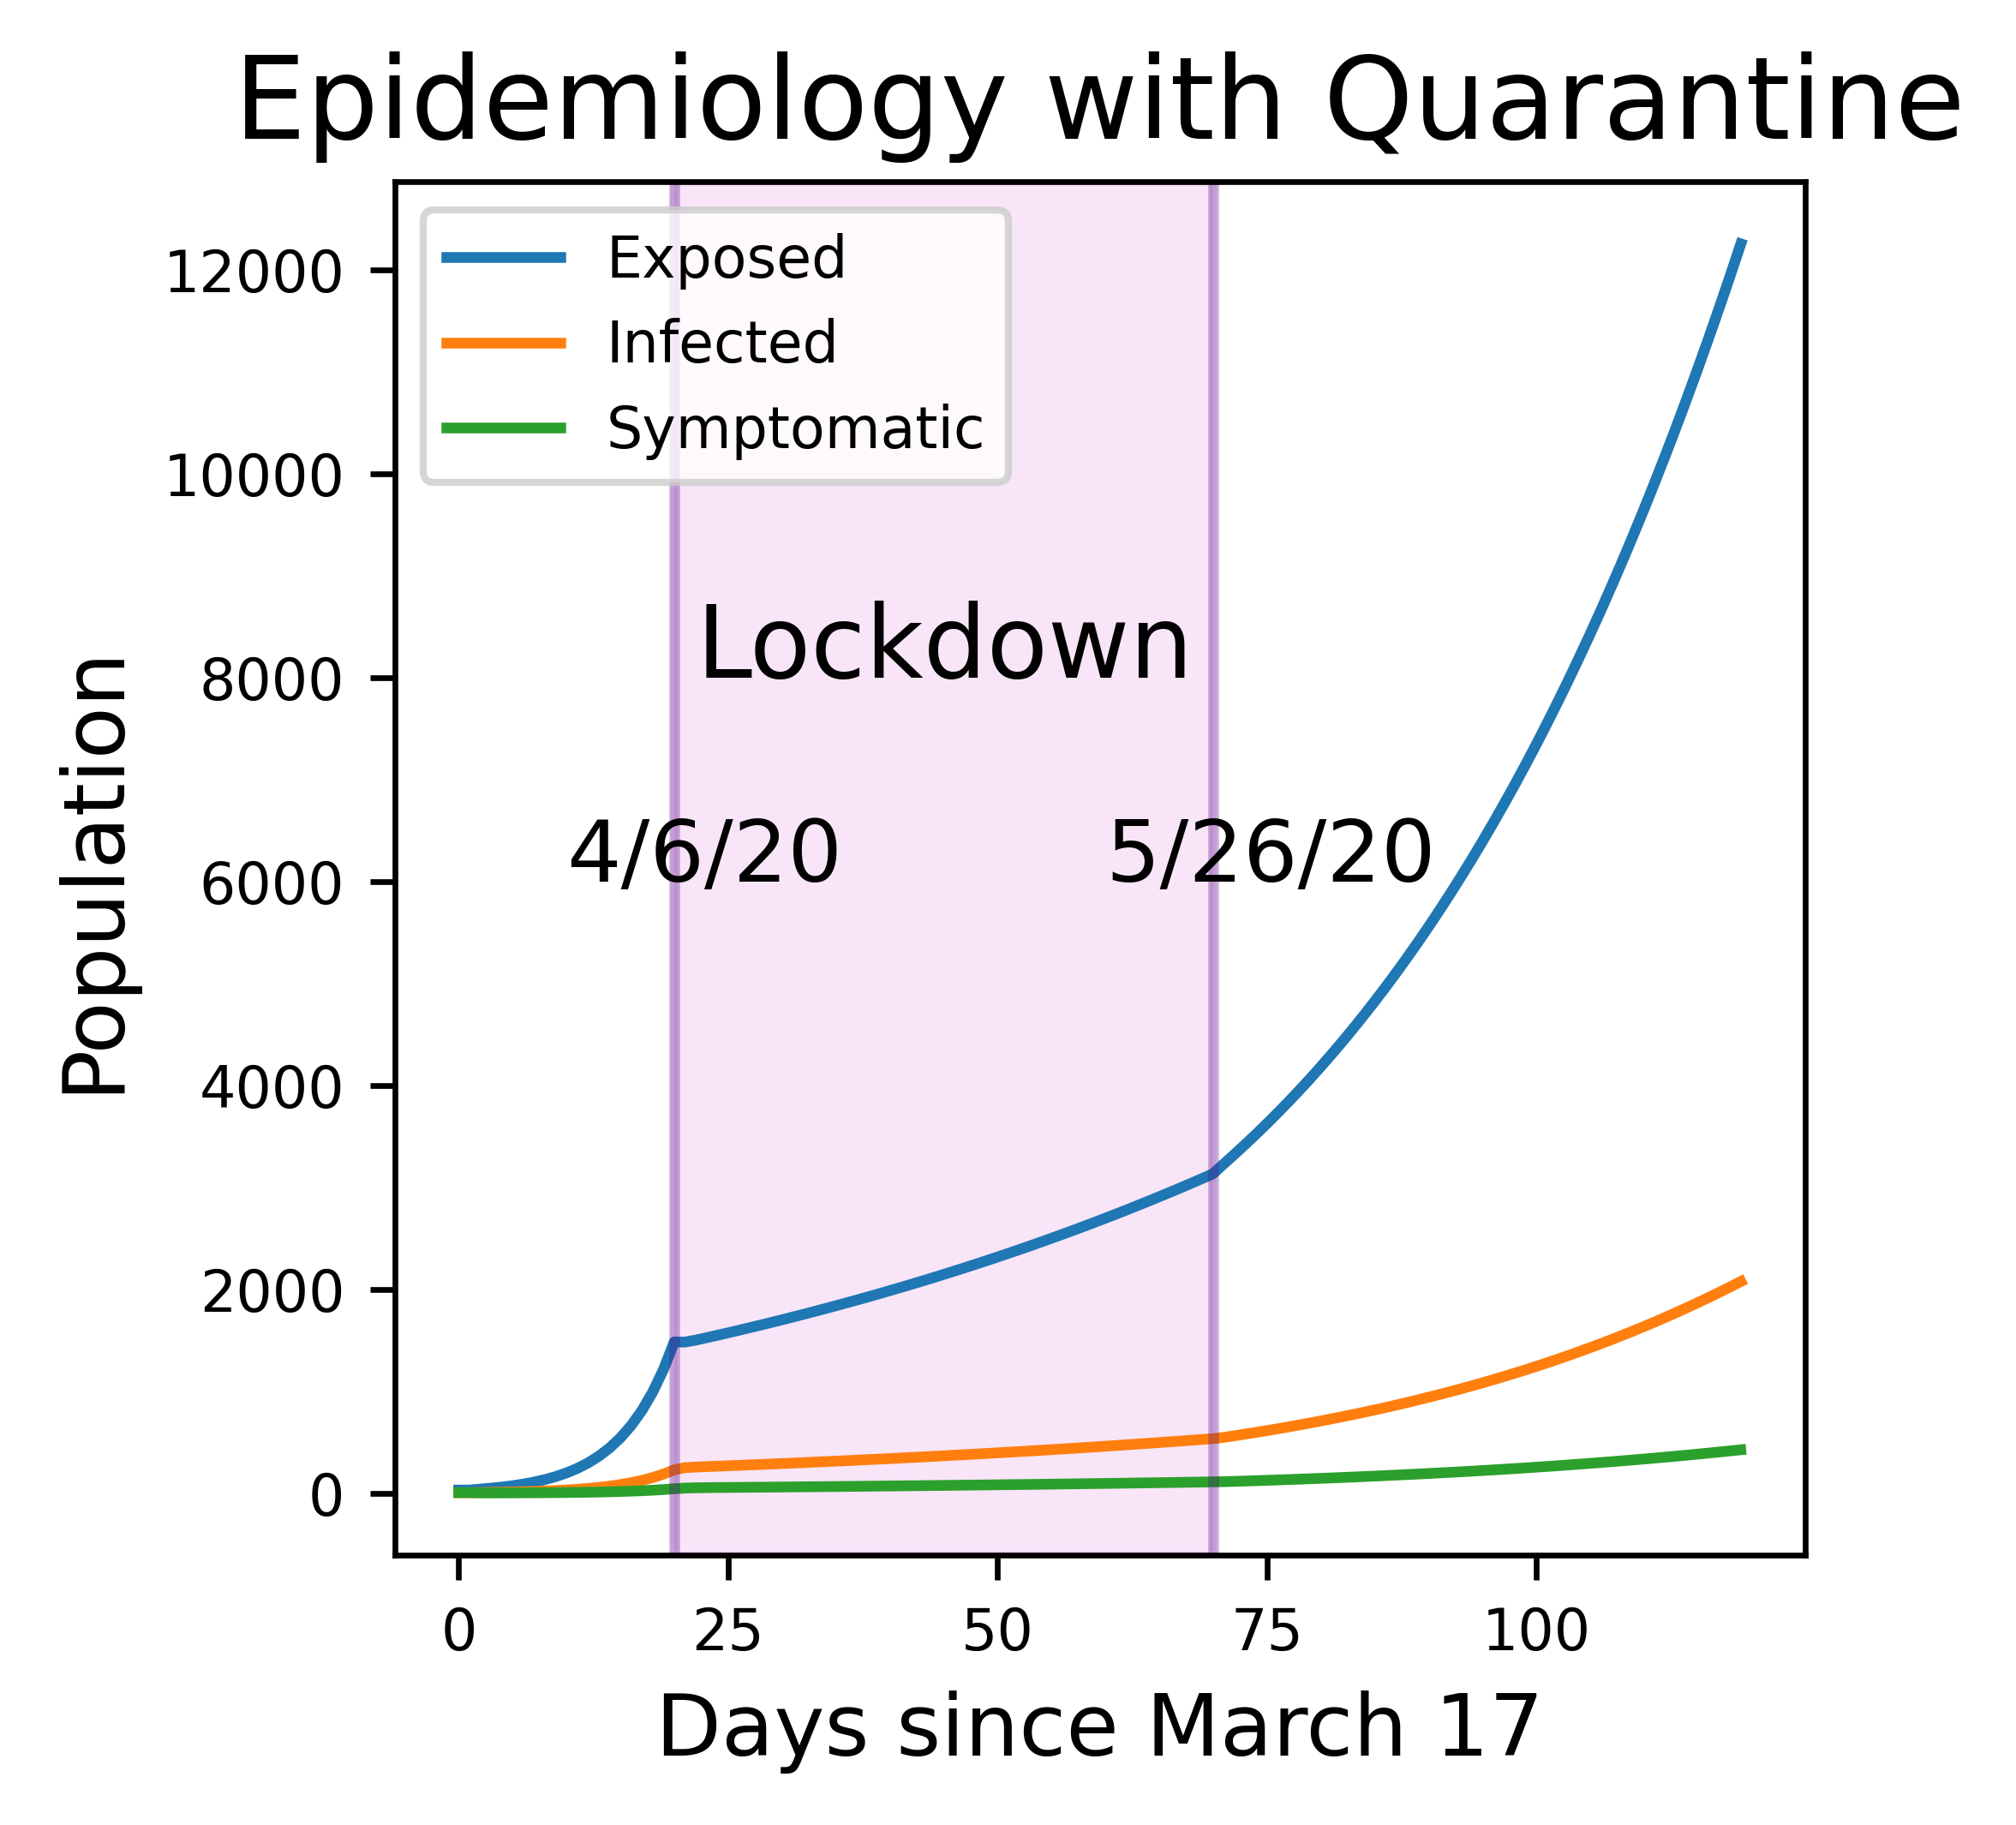

In [7]:
fig = plt.figure(figsize=(3.54,3.54), dpi=600)
plt.plot(results['time'], results['exposed'], label='Exposed')
plt.plot(results['time'], results['infected'], label='Infected')
plt.plot(results['time'], results['symptomatic'], label='Symptomatic')
plt.axvline(20, color='indigo', alpha=.3)
plt.axvline(70, color='indigo', alpha=.3)
plt.axvspan(20, 70, alpha=.1, color='m')
plt.annotate('Lockdown', (22, 8000), fontsize=14)
plt.annotate('4/6/20', (10, 6000), fontsize=12)
plt.annotate('5/26/20', (60, 6000), fontsize=12)
plt.title("Epidemiology with Quarantine", fontsize=16)
plt.xlabel('Days since March 17', fontsize=12)
plt.ylabel('Population', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(loc='best', fontsize=8)
plt.savefig('../images/Epidemiology_with_quarantine_event.pdf', bbox_inches='tight')